In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, ADAM, SPSA, GradientDescent, AQGD
from qiskit_machine_learning.utils import algorithm_globals


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
import os

# Establece la GPU a usar (en este caso la GPU #1)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
train = pd.read_csv("train_VQC.csv")
val = pd.read_csv("val_VQC.csv")
test = pd.read_csv("test_VQC.csv")

In [5]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category', 'ataque_original'])
y_train = train['category']

X_val = val.drop(columns=['category', 'ataque_original'])
y_val = val['category']

# Separar características y etiquetas para conjunto de prueba
X_test = test.drop(columns=['category', 'ataque_original'])
y_test= test['category']

# VARIATIONAL QUANTUM CLASSIFIER

In [6]:
from sklearn.preprocessing import LabelEncoder, label_binarize, MinMaxScaler
from tensorflow.keras.utils import to_categorical
import numpy as np
Max = 2 * np.pi
norm = MinMaxScaler(feature_range=(0, Max))
X_train = norm.fit_transform(X_train)
X_val = norm.transform(X_val)
X_test = norm.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)

# Convertir las etiquetas codificadas a codificación one-hot (10 columnas por muestras)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=2)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=2)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=2)

2025-06-10 05:03:42.168311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749531822.187623  313206 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749531822.193496  313206 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-10 05:03:42.214760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
history = []

def vqc_callback(weights, objective_value):
    history.append((weights.copy(), objective_value))
    print(f"Current loss: {objective_value:.6f}")



In [9]:
def simple_interpreter(x):
    return int("{:b}".format(x)[-1])  # qubit 0 (menos significativo)


In [9]:
history = []

def ADAM_callback(step, params, value):
    print(f"Step {step}: f(x) = {value:.5f}, params = {params}")
    history.append((params.copy(), value))


In [9]:
history = []

def SPSA_callback(nfev, params, value, step_size, accepted):
    print(f"Eval {nfev:03d} | f(x) = {value:.5f} | step = {step_size:.5f} | accepted = {accepted}")
    history.append((params.copy(), value, step_size, accepted))


In [8]:
from qiskit_ibm_runtime import SamplerV2, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_machine_learning.algorithms.classifiers import  VQC
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap

num_qubits = X_train.shape[1]

backend = AerSimulator(method='statevector', device='GPU')
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)
sampler = SamplerV2(mode=session)

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=500),
    callback=vqc_callback,
    sampler=sampler,
    pass_manager=pass_manager,
    output_shape=2
)

In [9]:
import time
start_time = time.time()
vqc.fit(X_train, y_train_one_hot)
end_time = time.time()
print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")

Current loss: 1.137440
Current loss: 1.012574
Current loss: 1.012375
Current loss: 1.011937
Current loss: 1.006206
Current loss: 1.006490
Current loss: 1.008297
Current loss: 1.003412
Current loss: 1.006062
Current loss: 1.008642
Current loss: 1.004484
Current loss: 1.008851
Current loss: 1.003605
Current loss: 0.999058
Current loss: 0.999590
Current loss: 0.984189
Current loss: 0.990859
Current loss: 0.995640
Current loss: 0.992391
Current loss: 1.030057
Current loss: 0.993187
Current loss: 1.002802
Current loss: 1.003919
Current loss: 1.030138
Current loss: 0.992054
Current loss: 1.002545
Current loss: 0.991155
Current loss: 0.994274
Current loss: 0.995825
Current loss: 1.017462
Current loss: 1.001924
Current loss: 0.984637
Current loss: 0.983777
Current loss: 0.984384
Current loss: 0.983963
Current loss: 0.984270
Current loss: 0.985236
Current loss: 0.984261
Current loss: 0.983804
Current loss: 0.984933
Current loss: 0.984278
Current loss: 0.984565
Current loss: 0.984708
Current los

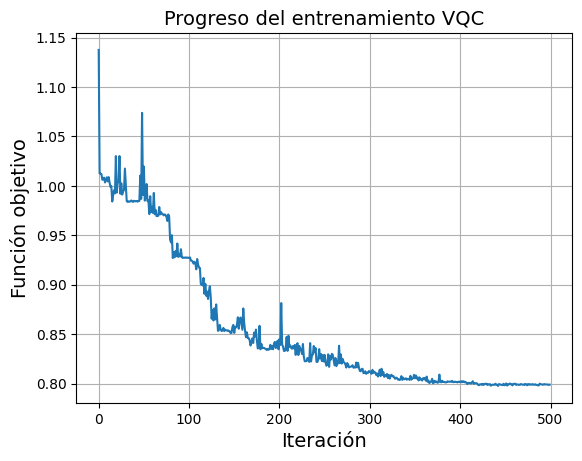

In [19]:
# Por ejemplo, plotear la evolución del loss
import matplotlib.pyplot as plt

losses = [entry[1] for entry in history]
plt.plot(losses)
plt.xlabel("Iteración", fontsize=14)
plt.ylabel("Función objetivo", fontsize=14)
plt.title("Progreso del entrenamiento VQC", fontsize=14)
plt.grid(True)
plt.savefig("vqc_training_200.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [11]:
start_time = time.time()
y_pred_proba = vqc.predict(X_test)
end_time = time.time()
print(f"Tiempo de predicción: {end_time - start_time} segundos")

Tiempo de predicción: 34.29062485694885 segundos


In [12]:
y_pred = np.argmax(y_pred_proba, axis=1)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_proba, y_test_one_hot)

0.7140620106482931

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test_encoded)

0.7140620106482931

In [15]:
start_time = time.time()
score = vqc.score(X_train, y_train_one_hot)
end_time = time.time()
print(f"Tiempo de evaluación: {end_time - start_time} segundos")
print(f"Train Score: {score}")

Tiempo de evaluación: 121.8173999786377 segundos
Train Score: 0.7189372931389212


In [16]:
print("Predicciones del clasificador:")
print(accuracy_score(y_pred, y_test_encoded))

Predicciones del clasificador:
0.7140620106482931


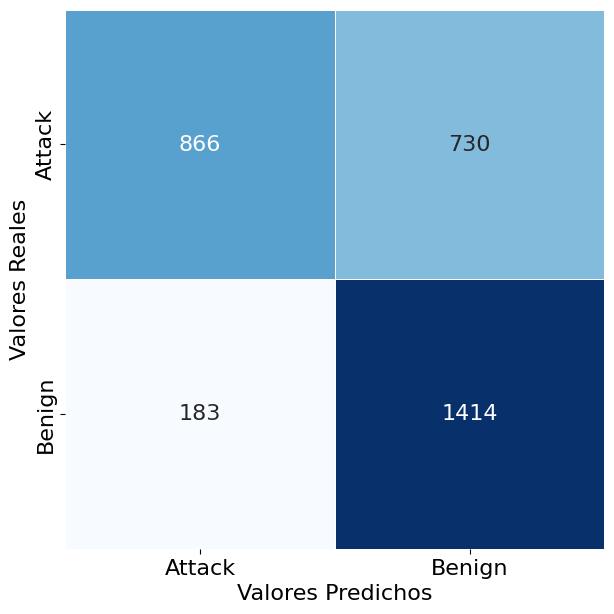

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Confusion matrix
cm = metrics.confusion_matrix(y_test_encoded, y_pred)
normalized_matrix = cm  # O normaliza si quieres: cm / cm.sum(axis=1, keepdims=True)

class_names = ['Attack', 'Benign']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 16}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=16)
plt.xlabel('Valores Predichos', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_VQC_200.pdf', format='pdf', bbox_inches='tight')

plt.show()


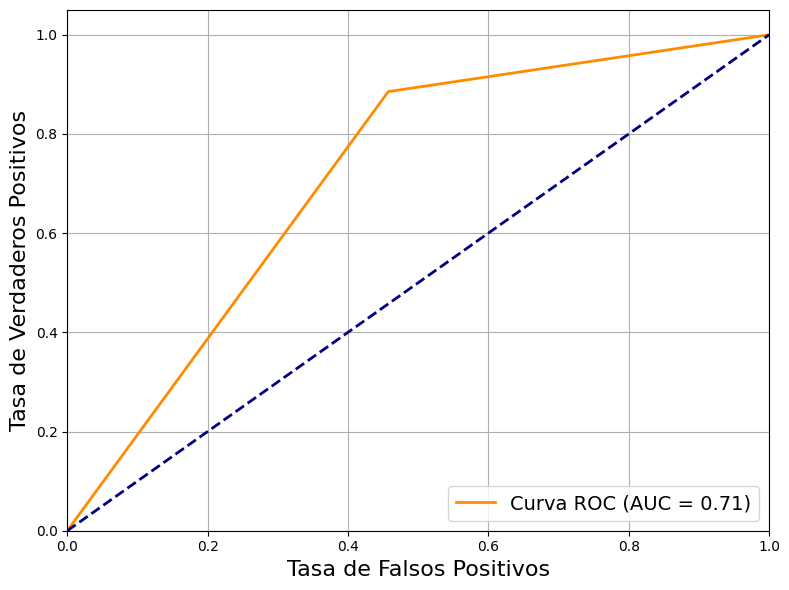

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC (usando las probabilidades de la clase positiva)
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)  # ← y_pred_proba, no y_pred
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=16)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=16)
#plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_VQC_200.pdf', format='pdf', bbox_inches='tight')
plt.show()
